<h4> Download some needed packages (especially SoccerNet)

In [1]:
%pip install SoccerNet opencv-python tqdm matplotlib pandas ultralytics torch torchvision --quiet


Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following versions that require a different python version: 8.0.10 Requires-Python >=3.7,<=3.11; 8.0.11 Requires-Python >=3.7,<=3.11; 8.0.12 Requires-Python >=3.7,<=3.11; 8.0.13 Requires-Python >=3.7,<=3.11; 8.0.14 Requires-Python >=3.7,<=3.11; 8.0.15 Requires-Python >=3.7,<=3.11; 8.0.16 Requires-Python >=3.7,<=3.11; 8.0.17 Requires-Python >=3.7,<=3.11; 8.0.18 Requires-Python >=3.7,<=3.11; 8.0.19 Requires-Python >=3.7,<=3.11; 8.0.20 Requires-Python >=3.7,<=3.11; 8.0.21 Requires-Python >=3.7,<=3.11; 8.0.22 Requires-Python >=3.7,<=3.11; 8.0.23 Requires-Python >=3.7,<=3.11; 8.0.24 Requires-Python >=3.7,<=3.11; 8.0.25 Requires-Python >=3.7,<=3.11; 8.0.26 Requires-Python >=3.7,<=3.11; 8.0.27 Requires-Python >=3.7,<=3.11; 8.0.28 Requires-Python >=3.7,<=3.11; 8.0.29 Requires-Python >=3.7,<=3.11; 8.0.30 Requires-Python >=3.7,<=3.11; 8.0.31 Requires-Python >=3.7,<=3.11; 8.0.32 Requires-Python >=3.7,<=3.11; 8.0.33 Requires-Python >=3.7,<=3.11; 8.0.34 Requires-Python >=3.7,<=3.

<h3> Downloading the content we need ...

In [2]:
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2

# -------------------------
# EDIT THESE PATHS
# -------------------------
SOCCERNET_DIR = Path("path/to/SoccerNet")      # root download directory
WORK_DIR      = Path("work")                  # where we'll build YOLO dataset, crops, outputs
WORK_DIR.mkdir(parents=True, exist_ok=True)

print("SOCCERNET_DIR:", SOCCERNET_DIR.resolve())
print("WORK_DIR:", WORK_DIR.resolve())


SOCCERNET_DIR: C:\Users\henri\Downloads\deep_learning_visualization\path\to\SoccerNet
WORK_DIR: C:\Users\henri\Downloads\deep_learning_visualization\work


21min to dl...

In [3]:
from SoccerNet.Downloader import SoccerNetDownloader
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="data/SoccerNetGS")
mySoccerNetDownloader.downloadDataTask(task="gamestate-2024",
                                       split=["train", "valid", "test", "challenge"])

data/SoccerNetGS\gamestate-2024\train.zip already exists
data/SoccerNetGS\gamestate-2024\valid.zip already exists
data/SoccerNetGS\gamestate-2024\test.zip already exists
data/SoccerNetGS\gamestate-2024\challenge.zip already exists


In [5]:
from pathlib import Path

DATA_ROOT = Path("data/SoccerNetGS")          # your LocalDirectory
ZIP_ROOT  = DATA_ROOT / "gamestate-2024"      # where the zips were downloaded

print("DATA_ROOT:", DATA_ROOT.resolve())
print("ZIP_ROOT :", ZIP_ROOT.resolve())
print("Zips found:", list(ZIP_ROOT.glob("*.zip")))


DATA_ROOT: C:\Users\henri\Downloads\deep_learning_visualization\data\SoccerNetGS
ZIP_ROOT : C:\Users\henri\Downloads\deep_learning_visualization\data\SoccerNetGS\gamestate-2024
Zips found: [WindowsPath('data/SoccerNetGS/gamestate-2024/challenge.zip'), WindowsPath('data/SoccerNetGS/gamestate-2024/test.zip'), WindowsPath('data/SoccerNetGS/gamestate-2024/train.zip'), WindowsPath('data/SoccerNetGS/gamestate-2024/valid.zip')]


16 min to unzip ...

In [6]:
import zipfile

def unzip(zip_path: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(out_dir)
    print(f"✅ Unzipped {zip_path.name} -> {out_dir}")

for split in ["train", "valid", "test", "challenge"]:
    z = ZIP_ROOT / f"{split}.zip"
    out = DATA_ROOT / split
    if not z.exists():
        print("❌ Missing zip:", z)
        continue
    # Skip if already unzipped (basic check)
    if out.exists() and any(out.iterdir()):
        print(f"⏭️  Looks already unzipped: {out}")
    else:
        unzip(z, out)


⏭️  Looks already unzipped: data\SoccerNetGS\train
⏭️  Looks already unzipped: data\SoccerNetGS\valid
⏭️  Looks already unzipped: data\SoccerNetGS\test
⏭️  Looks already unzipped: data\SoccerNetGS\challenge


In [7]:
def count_files(p: Path, pattern="*"):
    return len(list(p.rglob(pattern)))

for split in ["train", "valid", "test", "challenge"]:
    d = DATA_ROOT / split
    if not d.exists():
        continue
    print(f"\n=== {split.upper()} ===")
    print("folders:", len([x for x in d.iterdir() if x.is_dir()]))
    print("json:", count_files(d, "*.json"))
    print("mp4:", count_files(d, "*.mp4"))
    print("jpg:", count_files(d, "*.jpg"))
    print("png:", count_files(d, "*.png"))



=== TRAIN ===
folders: 57
json: 58
mp4: 0
jpg: 42750
png: 0

=== VALID ===
folders: 58
json: 59
mp4: 0
jpg: 43500
png: 0

=== TEST ===
folders: 49
json: 50
mp4: 0
jpg: 36750
png: 0

=== CHALLENGE ===
folders: 36
json: 1
mp4: 0
jpg: 27000
png: 0


In [8]:
import json

label_files = []
for split in ["train", "valid", "test", "challenge"]:
    label_files += list((DATA_ROOT / split).rglob("Labels-GameState.json"))

print("Found Labels-GameState.json:", len(label_files))
for p in label_files[:10]:
    print(" -", p)

if len(label_files) == 0:
    raise RuntimeError("No Labels-GameState.json found. The unzip or folder structure may be different.")

labels_path = label_files[0]
with open(labels_path, "r", encoding="utf-8") as f:
    labels = json.load(f)

print("Opened:", labels_path)
print("Top-level keys:", list(labels.keys())[:20])

# Version check
info = labels.get("info", {})
print("Dataset info:", info)
print("Version:", info.get("version"))


Found Labels-GameState.json: 164
 - data\SoccerNetGS\train\SNGS-060\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-061\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-062\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-063\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-064\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-065\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-066\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-067\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-068\Labels-GameState.json
 - data\SoccerNetGS\train\SNGS-069\Labels-GameState.json
Opened: data\SoccerNetGS\train\SNGS-060\Labels-GameState.json
Top-level keys: ['info', 'images', 'annotations', 'categories']
Dataset info: {'version': '1.3', 'game_id': '4', 'id': '060', 'num_tracklets': '26', 'action_position': '895', 'action_class': 'Kick-off', 'visibility': 'visible', 'game_time_start': '1 - 00:00', 'game_time_stop': '1 - 00:30', 'clip_start': '0', 'clip_stop': '30000', 'na

In [9]:
def preview_dict(d, n=20):
    for i, k in enumerate(d.keys()):
        if i >= n:
            break
        print(" -", k)

print("labels keys:")
preview_dict(labels, n=40)

# Try to guess where annotations live:
candidates = ["annotations", "data", "clips", "sequences", "games", "samples"]
for k in candidates:
    if k in labels:
        print("\n✅ Found likely annotation container:", k, "type:", type(labels[k]))


labels keys:
 - info
 - images
 - annotations
 - categories

✅ Found likely annotation container: annotations type: <class 'list'>


In [10]:
import os

def find_video_near(label_path: Path):
    # Often video is in same folder or a nearby folder
    base = label_path.parent
    vids = list(base.rglob("*.mp4"))
    if vids:
        return vids[0]
    # broaden search a bit
    vids = list(base.parent.rglob("*.mp4"))
    return vids[0] if vids else None

video_path = find_video_near(labels_path)
print("Video candidate:", video_path)


Video candidate: None


Sequence dir: data\SoccerNetGS\train\SNGS-060
Image dir: data\SoccerNetGS\train\SNGS-060\img1
Exists: True
Num frames: 750
First 5: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']


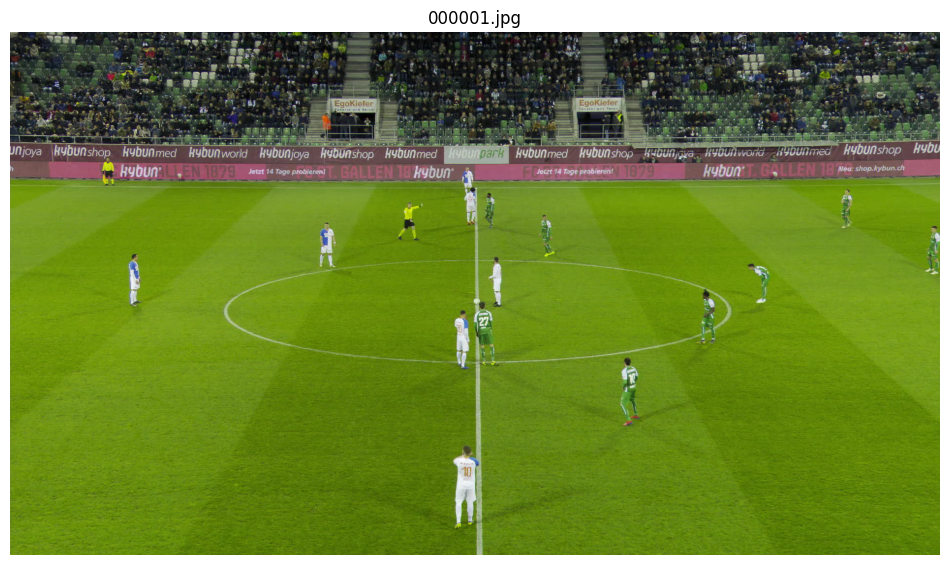

In [11]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

seq_dir = labels_path.parent  # .../train/SNGS-060
img_dir = seq_dir / labels["info"]["im_dir"]  # usually img1
print("Sequence dir:", seq_dir)
print("Image dir:", img_dir)
print("Exists:", img_dir.exists())

# list a few frames
jpgs = sorted(img_dir.glob("*.jpg"))
print("Num frames:", len(jpgs))
print("First 5:", [p.name for p in jpgs[:5]])

# load first frame
if len(jpgs) > 0:
    img_bgr = cv2.imread(str(jpgs[0]))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,7))
    plt.imshow(img_rgb)
    plt.title(jpgs[0].name)
    plt.axis("off")
    plt.show()


In [12]:
import pandas as pd

cats = labels["categories"]
df_cats = pd.DataFrame(cats)
df_cats


,supercategory,id,name,lines
0,object,1,player,NaN
1,object,2,goalkeeper,NaN
2,object,3,referee,NaN
3,object,4,ball,NaN
4,pitch,5,pitch,"[Big rect. left bottom, Big rect. left main, B..."
5,camera,6,camera,NaN
6,object,7,other,NaN


In [13]:
import random
import json

a = random.choice(labels["annotations"])
print("Annotation keys:", list(a.keys()))

# show full annotation (pretty)
print(json.dumps(a, indent=2)[:2000])  # truncate for readability


Annotation keys: ['id', 'image_id', 'track_id', 'supercategory', 'category_id', 'attributes', 'bbox_image', 'bbox_pitch', 'bbox_pitch_raw']
{
  "id": "1060014652",
  "image_id": "1060000735",
  "track_id": 10,
  "supercategory": "object",
  "category_id": 1,
  "attributes": {
    "role": "player",
    "jersey": null,
    "team": "right"
  },
  "bbox_image": {
    "x": 502,
    "y": 357,
    "x_center": 519.5,
    "y_center": 395.0,
    "w": 35,
    "h": 76
  },
  "bbox_pitch": {
    "x_bottom_left": -4.108728821604361,
    "y_bottom_left": -2.2570529771420023,
    "x_bottom_right": -3.35979128794158,
    "y_bottom_right": -2.1698832747673635,
    "x_bottom_middle": -3.7343009426144733,
    "y_bottom_middle": -2.213490622984721
  },
  "bbox_pitch_raw": {
    "x_bottom_left": -4.011426027577812,
    "y_bottom_left": -1.9034726552255097,
    "x_bottom_right": -3.228734371784015,
    "y_bottom_right": -1.81392609914603,
    "x_bottom_middle": -3.6201259104794286,
    "y_bottom_middle": -1.

In [14]:
# COCO bbox is [x, y, w, h] in pixels
im0 = labels["images"][0]
print("Image keys:", im0.keys())
print("Example image entry:", im0)

# find width/height if present
W = im0.get("width", None)
H = im0.get("height", None)
print("W,H:", W, H)


Image keys: dict_keys(['is_labeled', 'image_id', 'file_name', 'height', 'width', 'has_labeled_person', 'has_labeled_pitch', 'has_labeled_camera', 'ignore_regions_y', 'ignore_regions_x'])
Example image entry: {'is_labeled': True, 'image_id': '1060000001', 'file_name': '000001.jpg', 'height': 1080, 'width': 1920, 'has_labeled_person': True, 'has_labeled_pitch': True, 'has_labeled_camera': True, 'ignore_regions_y': [], 'ignore_regions_x': []}
W,H: 1920 1080


<h2> YOLO DETECTION DATASET

In [15]:
from collections import defaultdict
from pathlib import Path
import shutil
import cv2
import random

# classes for detection
KEEP_NAMES = ["player", "goalkeeper", "referee", "ball", "other"]
name_to_yolo = {n:i for i,n in enumerate(KEEP_NAMES)}

# category_id -> name
cat_id_to_name = {c["id"]: c["name"] for c in labels["categories"]}

# image_id -> file_name
img_id_to_name = {im["image_id"]: im["file_name"] for im in labels["images"]}

# group anns by image_id (but only if they are in our keep list)
anns_by_img = defaultdict(list)
for a in labels["annotations"]:
    cname = cat_id_to_name.get(a["category_id"])
    if cname in KEEP_NAMES and a.get("supercategory") == "object":
        anns_by_img[a["image_id"]].append(a)

print("Num images:", len(labels["images"]))
print("Num object-annotations:", sum(len(v) for v in anns_by_img.values()))


Num images: 750
Num object-annotations: 13540


In [16]:
YOLO_DIR = WORK_DIR / "yolo_gamestate_v13"
(img_train := YOLO_DIR/"images"/"train").mkdir(parents=True, exist_ok=True)
(lbl_train := YOLO_DIR/"labels"/"train").mkdir(parents=True, exist_ok=True)
(img_val   := YOLO_DIR/"images"/"val").mkdir(parents=True, exist_ok=True)
(lbl_val   := YOLO_DIR/"labels"/"val").mkdir(parents=True, exist_ok=True)

def bbox_image_to_yolo(b, W, H):
    # bbox_image: {x,y,w,h,x_center,y_center}
    cx = b["x_center"] / W
    cy = b["y_center"] / H
    nw = b["w"] / W
    nh = b["h"] / H
    return cx, cy, nw, nh

# get sorted image_ids from this sequence
all_img_ids = sorted(img_id_to_name.keys(), key=lambda s: int(s))  # they are strings
cut = int(0.8 * len(all_img_ids))
train_ids = set(all_img_ids[:cut])
val_ids   = set(all_img_ids[cut:])

def export_yolo(img_ids, out_img, out_lbl, max_images=None):
    exported = 0
    for img_id in img_ids:
        fname = img_id_to_name[img_id]
        src = img_dir / fname
        if not src.exists():
            continue

        im = cv2.imread(str(src))
        if im is None:
            continue
        H, W = im.shape[:2]

        lines = []
        for a in anns_by_img.get(img_id, []):
            cname = cat_id_to_name[a["category_id"]]
            cls = name_to_yolo[cname]
            b = a["bbox_image"]
            cx, cy, nw, nh = bbox_image_to_yolo(b, W, H)
            lines.append(f"{cls} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}")

        if len(lines) == 0:
            continue

        shutil.copy2(src, out_img / fname)
        (out_lbl / (Path(fname).stem + ".txt")).write_text("\n".join(lines))
        exported += 1
        if max_images and exported >= max_images:
            break
    return exported

ntr = export_yolo(sorted(train_ids, key=lambda s: int(s)), img_train, lbl_train, max_images=2000)
nva = export_yolo(sorted(val_ids, key=lambda s: int(s)), img_val, lbl_val, max_images=500)

print("Exported train:", ntr, "val:", nva)
print("YOLO_DIR:", YOLO_DIR)


Exported train: 600 val: 150
YOLO_DIR: work\yolo_gamestate_v13


In [17]:
data_yaml = f"""
path: {YOLO_DIR.as_posix()}
train: images/train
val: images/val

names:
{chr(10).join([f"  {i}: {n}" for n,i in name_to_yolo.items()])}
""".strip()

(YOLO_DIR/"data.yaml").write_text(data_yaml)
print((YOLO_DIR/"data.yaml").read_text())


path: work/yolo_gamestate_v13
train: images/train
val: images/val

names:
  0: player
  1: goalkeeper
  2: referee
  3: ball
  4: other


In [28]:
!pip install ultralytics

  Using cached ultralytics-8.3.240-py3-none-any.whl.metadata (37 kB)
  Using cached torchvision-0.24.1-cp312-cp312-win_amd64.whl.metadata (5.9 kB)
  Using cached ultralytics_thop-2.0.18-py3-none-any.whl.metadata (14 kB)
Using cached ultralytics-8.3.240-py3-none-any.whl (1.1 MB)
Using cached torchvision-0.24.1-cp312-cp312-win_amd64.whl (4.3 MB)
Using cached ultralytics_thop-2.0.18-py3-none-any.whl (28 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(
    data=str(YOLO_DIR/"data.yaml"),
    imgsz=640,
    epochs=10,
    batch=8,
    project=str(WORK_DIR/"runs"),
    name="yolo_gamestate_v13_seq060"
)


New https://pypi.org/project/ultralytics/8.3.241 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.240  Python-3.12.6 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=work\yolo_gamestate_v13\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_gamestate_v13_seq0602, nbs

KeyboardInterrupt: 

<h2> Team classifier dataset

In [19]:
import os

CROPS_DIR = WORK_DIR / "team_crops"
(left_dir := CROPS_DIR/"left").mkdir(parents=True, exist_ok=True)
(right_dir:= CROPS_DIR/"right").mkdir(parents=True, exist_ok=True)

def export_team_crops(max_frames=300, crops_per_frame=20):
    # sample frames that have annotations
    img_ids = [img_id for img_id in all_img_ids if img_id in anns_by_img]
    img_ids = img_ids[:max_frames]

    saved = 0
    for img_id in img_ids:
        fname = img_id_to_name[img_id]
        path = img_dir / fname
        im = cv2.imread(str(path))
        if im is None:
            continue
        H, W = im.shape[:2]

        # keep only players+goalkeepers for team crops
        obj_anns = [a for a in anns_by_img[img_id] if cat_id_to_name[a["category_id"]] in ["player","goalkeeper"]]
        random.shuffle(obj_anns)

        for a in obj_anns[:crops_per_frame]:
            attrs = a.get("attributes", {})
            team = attrs.get("team", None)
            if team not in ["left", "right"]:
                continue

            b = a["bbox_image"]
            x1 = max(0, int(b["x"]))
            y1 = max(0, int(b["y"]))
            x2 = min(W, int(b["x"] + b["w"]))
            y2 = min(H, int(b["y"] + b["h"]))
            if (x2-x1) < 12 or (y2-y1) < 12:
                continue

            crop = im[y1:y2, x1:x2]
            outdir = left_dir if team == "left" else right_dir
            outname = f"{fname[:-4]}_tid{a['track_id']}_jer{attrs.get('jersey','NA')}_{saved:06d}.jpg"
            cv2.imwrite(str(outdir/outname), crop)
            saved += 1

    print("Saved team crops:", saved, "to", CROPS_DIR)

export_team_crops(max_frames=400, crops_per_frame=25)


Saved team crops: 5962 to work\team_crops


In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

ds = datasets.ImageFolder(str(CROPS_DIR), transform=tfm)  # expects left/ right folders
print("Classes:", ds.classes, "N:", len(ds))

# train/val split
n_val = int(0.2 * len(ds))
n_train = len(ds) - n_val
train_ds, val_ds = random_split(ds, [n_train, n_val])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

def eval_acc(dl):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x,y in dl:
            x,y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred==y).sum().item()
            total += y.numel()
    model.train()
    return correct/total if total else 0

for epoch in range(5):
    running = 0.0
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        running += loss.item() * x.size(0)

    tr_loss = running / len(train_ds)
    va_acc = eval_acc(val_dl)
    print(f"epoch {epoch+1}: train_loss={tr_loss:.4f} val_acc={va_acc:.3f}")

torch.save(model.state_dict(), str(WORK_DIR/"team_resnet18_left_right.pt"))
print("Saved:", WORK_DIR/"team_resnet18_left_right.pt")


device: cpu
Classes: ['left', 'right'] N: 11536


KeyboardInterrupt: 

<h2> Heatmaps in pitch coordinates

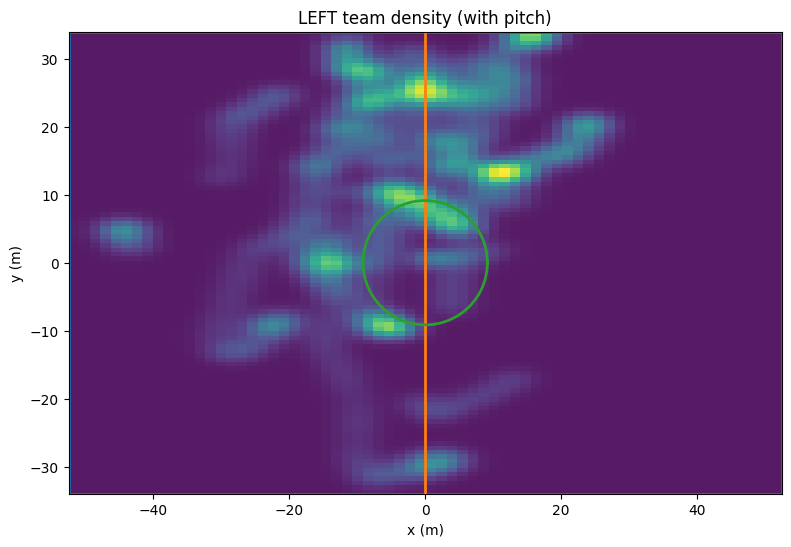

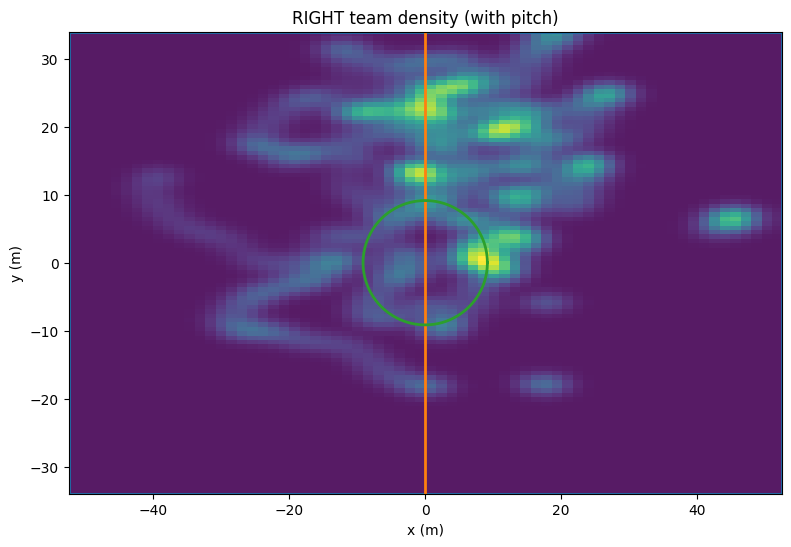

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def draw_pitch(ax, xlim=(-52.5, 52.5), ylim=(-34, 34)):
    # outer lines
    ax.plot([xlim[0], xlim[1], xlim[1], xlim[0], xlim[0]],
            [ylim[0], ylim[0], ylim[1], ylim[1], ylim[0]], linewidth=2)

    # halfway line
    ax.plot([0, 0], [ylim[0], ylim[1]], linewidth=2)

    # center circle (r = 9.15m)
    r = 9.15
    t = np.linspace(0, 2*np.pi, 200)
    ax.plot(r*np.cos(t), r*np.sin(t), linewidth=2)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

def heatmap(points, bins=(105, 68), xlim=(-52.5, 52.5), ylim=(-34, 34), blur_sigma=1.6):
    x = points[:,0]; y = points[:,1]
    H, _, _ = np.histogram2d(y, x, bins=bins, range=[ylim, xlim])
    H = cv2.GaussianBlur(H.astype(np.float32), (0,0), sigmaX=blur_sigma, sigmaY=blur_sigma)
    return H

def plot_pitch_heat(points, title):
    H = heatmap(points)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(H, origin="lower", extent=[-52.5, 52.5, -34, 34], alpha=0.9)
    draw_pitch(ax)
    ax.set_title(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    plt.show()

plot_pitch_heat(left_pts,  "LEFT team density (with pitch)")
plot_pitch_heat(right_pts, "RIGHT team density (with pitch)")


<h3> Average position per player 

In [20]:
from collections import defaultdict
import numpy as np

# track_id -> list of (x,y) pitch points
track_points = defaultdict(list)

# meta for each track (team, jersey, role)
track_meta = {}

for a in labels["annotations"]:
    if a.get("supercategory") != "object":
        continue

    attrs = a.get("attributes", {})
    team = attrs.get("team")
    role = attrs.get("role")
    jersey = attrs.get("jersey", None)
    tid = a.get("track_id", None)
    bp = a.get("bbox_pitch", {})

    if tid is None or team not in ["left", "right"]:
        continue
    if "x_bottom_middle" not in bp or "y_bottom_middle" not in bp:
        continue
    if role not in ["player", "goalkeeper"]:
        continue  # skip referee/other/ball

    x = float(bp["x_bottom_middle"])
    y = float(bp["y_bottom_middle"])

    track_points[tid].append((x, y))
    # store meta once
    if tid not in track_meta:
        track_meta[tid] = {"team": team, "jersey": jersey, "role": role}

print("Num tracks:", len(track_points))
# show top 5 by number of points
top = sorted(track_points.items(), key=lambda kv: len(kv[1]), reverse=True)[:5]
for tid, pts in top:
    print("track", tid, "N=", len(pts), "meta=", track_meta[tid])


Num tracks: 22
track 2 N= 750 meta= {'team': 'left', 'jersey': '30', 'role': 'player'}
track 8 N= 750 meta= {'team': 'right', 'jersey': '4', 'role': 'player'}
track 7 N= 687 meta= {'team': 'right', 'jersey': '8', 'role': 'player'}
track 9 N= 682 meta= {'team': 'right', 'jersey': '14', 'role': 'player'}
track 16 N= 622 meta= {'team': 'left', 'jersey': '8', 'role': 'player'}


In [21]:
import pandas as pd

rows = []
for tid, pts in track_points.items():
    arr = np.array(pts)
    x_mean, y_mean = arr.mean(axis=0)
    x_std, y_std = arr.std(axis=0)
    n = len(arr)
    meta = track_meta.get(tid, {})
    rows.append({
        "track_id": tid,
        "team": meta.get("team"),
        "role": meta.get("role"),
        "jersey": meta.get("jersey"),
        "n_points": n,
        "x_mean": x_mean,
        "y_mean": y_mean,
        "x_std": x_std,
        "y_std": y_std
    })

df_tracks = pd.DataFrame(rows).sort_values(["team", "n_points"], ascending=[True, False])
df_tracks.head(10)


,track_id,team,role,jersey,n_points,x_mean,y_mean,x_std,y_std
1,2,left,player,30,750,3.004775,17.908902,5.413501,7.127330
14,16,left,player,8,622,-9.291480,11.454865,7.861743,9.875384
13,15,left,player,None,602,-5.972493,0.169543,1.560345,8.106227
11,12,left,player,25,586,6.482467,2.455676,3.184465,11.597664
0,1,left,player,10,578,6.071579,28.169378,6.645280,3.208146
10,11,left,player,3,548,15.392848,13.020652,7.176794,6.603319
15,19,left,player,None,543,-16.090734,1.859469,12.080106,10.823362
16,20,left,player,24,505,-8.252510,27.449336,3.350056,2.525345
12,13,left,player,None,493,-7.893826,-17.535578,6.390939,13.412094
17,21,left,player,4,277,-19.889268,19.963491,7.540484,3.233908


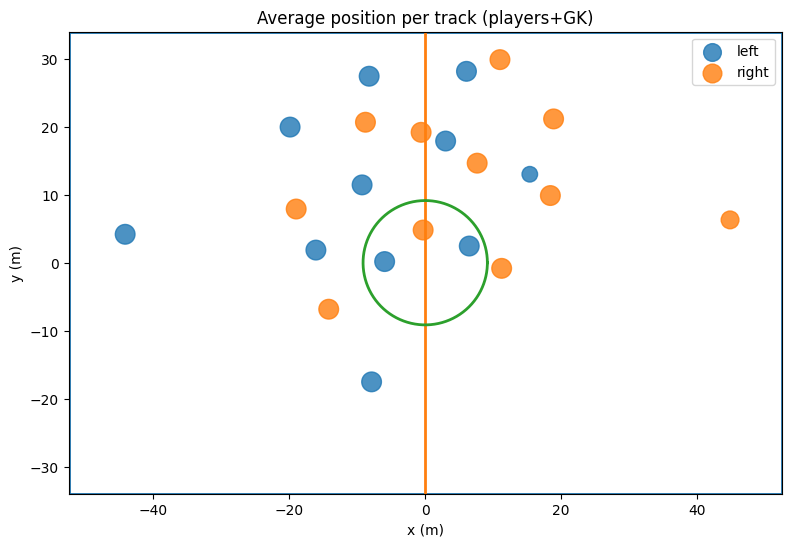

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def draw_pitch(ax, xlim=(-52.5, 52.5), ylim=(-34, 34)):
    ax.plot([xlim[0], xlim[1], xlim[1], xlim[0], xlim[0]],
            [ylim[0], ylim[0], ylim[1], ylim[1], ylim[0]], linewidth=2)
    ax.plot([0, 0], [ylim[0], ylim[1]], linewidth=2)  # halfway line

    # center circle
    r = 9.15
    t = np.linspace(0, 2*np.pi, 200)
    ax.plot(r*np.cos(t), r*np.sin(t), linewidth=2)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")

def plot_avg_positions(df, title="Average positions"):
    fig, ax = plt.subplots(figsize=(10,6))
    draw_pitch(ax)

    # size by time-on-screen (n_points), with a cap so it stays readable
    sizes = np.clip(df["n_points"].to_numpy(), 10, 200)

    # plot left and right separately (no manual colors; matplotlib default will differ)
    for team in ["left", "right"]:
        sub = df[df["team"] == team]
        ax.scatter(sub["x_mean"], sub["y_mean"], s=sizes[sub.index], label=team, alpha=0.8)

    ax.legend()
    ax.set_title(title)
    plt.show()

plot_avg_positions(df_tracks, title="Average position per track (players+GK)")


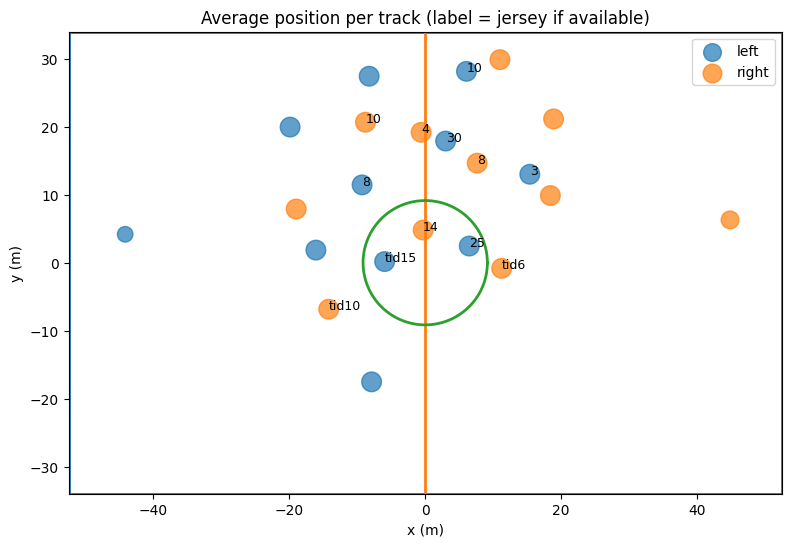

In [25]:
def plot_avg_positions_labeled(df, k=8, title="Average positions (labeled top tracks)"):
    fig, ax = plt.subplots(figsize=(10,6))
    draw_pitch(ax)

    for team in ["left", "right"]:
        sub = df[df["team"] == team]
        sizes = np.clip(sub["n_points"].to_numpy(), 10, 200)
        ax.scatter(sub["x_mean"], sub["y_mean"], s=sizes, label=team, alpha=0.7)

        # label top-k by n_points
        topk = sub.sort_values("n_points", ascending=False).head(k)
        for _, r in topk.iterrows():
            label = f"{r['jersey']}" if pd.notna(r["jersey"]) else f"tid{r['track_id']}"
            ax.text(r["x_mean"], r["y_mean"], str(label), fontsize=9)

    ax.legend()
    ax.set_title(title)
    plt.show()

plot_avg_positions_labeled(df_tracks, k=6, title="Average position per track (label = jersey if available)")


Instead of first clip (30 secs) Lets do the whole match for this game.

In [27]:
from pathlib import Path
import json

DATA_ROOT = Path(r"data\SoccerNetGS")
TARGET_GAME_ID = "4"  # your SNGS-060 had game_id = "4"

label_paths = list(DATA_ROOT.rglob("Labels-GameState.json"))

clips = []
for p in label_paths:
    try:
        lab = json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        continue

    info = lab.get("info", {})
    if str(info.get("game_id")) != TARGET_GAME_ID:
        continue

    # "1 - 00:00" -> half = "1"
    gts = str(info.get("game_time_start", ""))
    half = gts.split("-")[0].strip() if "-" in gts else None
    if half not in ["1", "2"]:
        continue

    clips.append({
        "path": p,
        "half": half,
        "name": info.get("name", p.parent.name),
        "labels": lab
    })

print("Clips found for game", TARGET_GAME_ID, ":", len(clips))
print("Half 1:", sum(c["half"]=="1" for c in clips), "| Half 2:", sum(c["half"]=="2" for c in clips))
print("Example:", clips[0]["name"], clips[0]["path"])


Clips found for game 4 : 18
Half 1: 9 | Half 2: 9
Example: SNGS-060 data\SoccerNetGS\train\SNGS-060\Labels-GameState.json


In [28]:
def extract_jersey_sets(lab):
    # returns jerseys_by_team: {"left": set(...), "right": set(...)}
    jerseys_by_team = {"left": set(), "right": set()}
    for a in lab["annotations"]:
        if a.get("supercategory") != "object":
            continue
        attrs = a.get("attributes", {})
        team = attrs.get("team")
        role = attrs.get("role")
        jersey = attrs.get("jersey")
        if team in ["left","right"] and role in ["player","goalkeeper"] and jersey not in [None, "", "null"]:
            jerseys_by_team[team].add(str(jersey))
    return jerseys_by_team

# aggregate jersey sets across all clips within each half
half_jerseys = {
    "1": {"left": set(), "right": set()},
    "2": {"left": set(), "right": set()},
}

for c in clips:
    js = extract_jersey_sets(c["labels"])
    for t in ["left","right"]:
        half_jerseys[c["half"]][t] |= js[t]

def jaccard(a, b):
    return len(a & b) / max(1, len(a | b))

# Compare overlap to decide mapping:
# We define TeamA as "half1-left" by convention, then see in half2 whether TeamA aligns with left or right.
A_half1 = half_jerseys["1"]["left"]
score_A_to_left2  = jaccard(A_half1, half_jerseys["2"]["left"])
score_A_to_right2 = jaccard(A_half1, half_jerseys["2"]["right"])

if score_A_to_left2 >= score_A_to_right2:
    map_half2 = {"left": "TeamA", "right": "TeamB"}
else:
    map_half2 = {"left": "TeamB", "right": "TeamA"}

map_half1 = {"left": "TeamA", "right": "TeamB"}

print("Jersey overlap TeamA(half1-left) with half2-left:", score_A_to_left2)
print("Jersey overlap TeamA(half1-left) with half2-right:", score_A_to_right2)
print("Mapping half1:", map_half1)
print("Mapping half2:", map_half2)


Jersey overlap TeamA(half1-left) with half2-left: 0.19047619047619047
Jersey overlap TeamA(half1-left) with half2-right: 0.6666666666666666
Mapping half1: {'left': 'TeamA', 'right': 'TeamB'}
Mapping half2: {'left': 'TeamB', 'right': 'TeamA'}


In [31]:
import numpy as np

team_points = {"TeamA": [], "TeamB": []}

for c in clips:
    lab = c["labels"]
    mapping = map_half1 if c["half"] == "1" else map_half2

    for a in lab["annotations"]:
        if a.get("supercategory") != "object":
            continue

        attrs = a.get("attributes", {})
        team_lr = attrs.get("team")
        role = attrs.get("role")
        if team_lr not in ["left","right"] or role not in ["player","goalkeeper"]:
            continue

        bp = a.get("bbox_pitch") or {}   # ✅ handles None safely
        x = bp.get("x_bottom_middle")
        y = bp.get("y_bottom_middle")
        if x is None or y is None:
            continue

        team = mapping[team_lr]  # TeamA/TeamB
        team_points[team].append((float(x), float(y)))

for t in ["TeamA", "TeamB"]:
    arr = np.array(team_points[t])
    print(t, "points:", arr.shape)


TeamA points: (109655, 2)
TeamB points: (106204, 2)


In [32]:
def mean_gk_x_for_half(team_name, half):
    xs = []
    for c in clips:
        if c["half"] != half:
            continue
        lab = c["labels"]
        mapping = map_half1 if half=="1" else map_half2

        for a in lab["annotations"]:
            if a.get("supercategory") != "object":
                continue
            attrs = a.get("attributes", {})
            if attrs.get("role") != "goalkeeper":
                continue
            team_lr = attrs.get("team")
            if team_lr not in ["left","right"]:
                continue
            team = mapping[team_lr]
            if team != team_name:
                continue
            bp = a.get("bbox_pitch", {})
            if "x_bottom_middle" in bp:
                xs.append(float(bp["x_bottom_middle"]))
    return float(np.mean(xs)) if xs else None

gk_x_h1 = mean_gk_x_for_half("TeamA", "1")
gk_x_h2 = mean_gk_x_for_half("TeamA", "2")
print("TeamA GK mean x half1:", gk_x_h1)
print("TeamA GK mean x half2:", gk_x_h2)

# If GK is on opposite side (sign flips), flip x for half2 to align directions
FLIP_HALF2 = (gk_x_h1 is not None and gk_x_h2 is not None and (gk_x_h1 * gk_x_h2) < 0)
print("Flip x in half2 to align attacking direction?", FLIP_HALF2)


TeamA GK mean x half1: -45.76808426933391
TeamA GK mean x half2: 50.30308370733999
Flip x in half2 to align attacking direction? True


In [34]:
team_points_aligned = {"TeamA": [], "TeamB": []}

for c in clips:
    lab = c["labels"]
    half = c["half"]
    mapping = map_half1 if half == "1" else map_half2
    flip = (half == "2" and FLIP_HALF2)

    for a in lab["annotations"]:
        if a.get("supercategory") != "object":
            continue

        attrs = a.get("attributes", {})
        team_lr = attrs.get("team")
        role = attrs.get("role")
        if team_lr not in ["left","right"] or role not in ["player","goalkeeper"]:
            continue

        bp = a.get("bbox_pitch") or {}     # ✅ handle None
        x = bp.get("x_bottom_middle")
        y = bp.get("y_bottom_middle")
        if x is None or y is None:
            continue

        x = float(x)
        y = float(y)
        if flip:
            x = -x  # mirror around midfield line

        team = mapping[team_lr]
        team_points_aligned[team].append((x, y))

print("Aligned TeamA points:", len(team_points_aligned["TeamA"]))
print("Aligned TeamB points:", len(team_points_aligned["TeamB"]))


Aligned TeamA points: 109655
Aligned TeamB points: 106204


In [36]:
from collections import defaultdict
import pandas as pd
import numpy as np

track_points = defaultdict(list)
track_meta = {}

for c in clips:
    lab = c["labels"]
    half = c["half"]
    mapping = map_half1 if half == "1" else map_half2
    flip = (half == "2" and FLIP_HALF2)

    clip_name = c["name"]

    for a in lab["annotations"]:
        if a.get("supercategory") != "object":
            continue

        attrs = a.get("attributes", {})
        role = attrs.get("role")
        team_lr = attrs.get("team")
        if role not in ["player", "goalkeeper"] or team_lr not in ["left", "right"]:
            continue

        bp = a.get("bbox_pitch") or {}      # ✅ handles None
        x = bp.get("x_bottom_middle")
        y = bp.get("y_bottom_middle")
        if x is None or y is None:
            continue

        tid = a.get("track_id")
        if tid is None:
            continue

        x = float(x)
        y = float(y)
        if flip:
            x = -x

        track_key = (clip_name, tid)        # unique across whole match
        team = mapping[team_lr]             # TeamA/TeamB

        track_points[track_key].append((x, y))
        if track_key not in track_meta:
            track_meta[track_key] = {
                "team": team,
                "half": half,
                "role": role,
                "jersey": attrs.get("jersey")
            }

rows = []
for k, pts in track_points.items():
    arr = np.array(pts, dtype=float)
    rows.append({
        "clip": k[0],
        "track_id": k[1],
        "team": track_meta[k]["team"],
        "half": track_meta[k]["half"],
        "role": track_meta[k]["role"],
        "jersey": track_meta[k]["jersey"],
        "n_points": len(arr),
        "x_mean": float(arr[:, 0].mean()),
        "y_mean": float(arr[:, 1].mean()),
        "x_std":  float(arr[:, 0].std()),
        "y_std":  float(arr[:, 1].std()),
    })

df_avg = pd.DataFrame(rows).sort_values(["team", "n_points"], ascending=[True, False])
df_avg.head(15)


,clip,track_id,team,half,role,jersey,n_points,x_mean,y_mean,x_std,y_std
1,SNGS-060,2,TeamA,1,player,30,750,3.004775,17.908902,5.413501,7.127330
29,SNGS-061,11,TeamA,1,player,30,750,11.066729,12.585883,24.210475,8.703391
88,SNGS-064,2,TeamA,1,player,4,750,-34.526099,4.026950,3.741277,2.593407
89,SNGS-064,3,TeamA,1,player,3,750,-34.534268,0.201328,3.959681,4.626998
90,SNGS-064,4,TeamA,1,player,8,750,-33.534158,0.143268,3.768609,1.431384
91,SNGS-064,5,TeamA,1,player,17,750,-33.818941,1.283665,5.948159,4.795382
92,SNGS-064,6,TeamA,1,player,10,750,-30.026589,1.209332,6.932205,4.984799
93,SNGS-064,7,TeamA,1,player,25,750,-32.159330,0.169625,3.695196,3.768269
113,SNGS-065,6,TeamA,1,player,None,750,-3.362448,-23.919012,5.120957,9.022410
141,SNGS-066,13,TeamA,1,player,24,750,-22.714608,15.972582,17.831040,5.916129


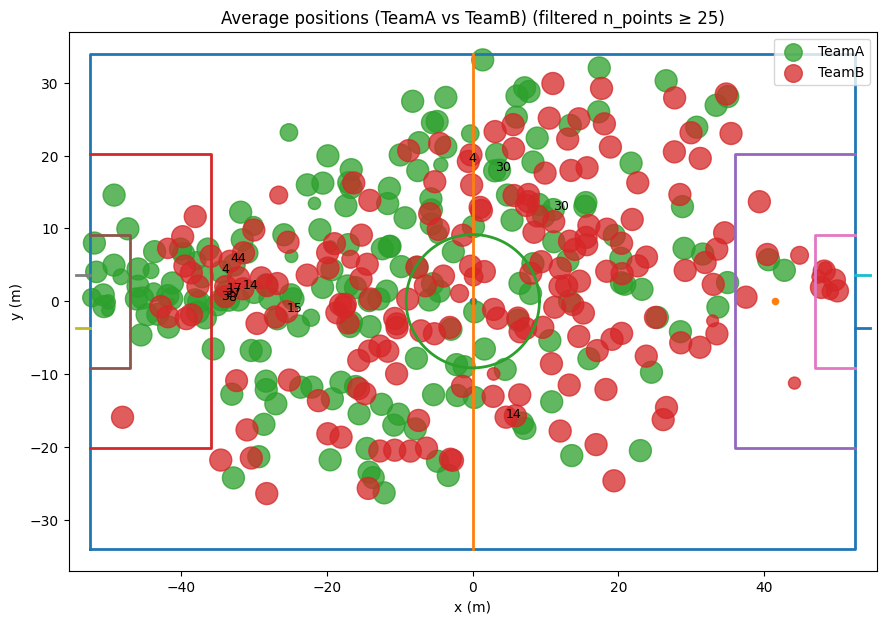

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# --- Pitch drawing (centered at (0,0), x in [-52.5, 52.5], y in [-34, 34]) ---
def draw_pitch(ax, xlim=(-52.5, 52.5), ylim=(-34, 34)):
    # Outer boundary
    ax.plot([xlim[0], xlim[1], xlim[1], xlim[0], xlim[0]],
            [ylim[0], ylim[0], ylim[1], ylim[1], ylim[0]], linewidth=2)
    # Halfway line
    ax.plot([0, 0], [ylim[0], ylim[1]], linewidth=2)

    # Center circle + center spot
    r = 9.15
    t = np.linspace(0, 2*np.pi, 300)
    ax.plot(r*np.cos(t), r*np.sin(t), linewidth=2)
    ax.scatter([0], [0], s=20)

    # Penalty areas (depth 16.5, width 40.3)
    pa_depth = 16.5
    pa_half_w = 40.32 / 2
    # Left penalty area
    ax.plot([-52.5, -52.5+pa_depth, -52.5+pa_depth, -52.5],
            [ pa_half_w,  pa_half_w, -pa_half_w, -pa_half_w], linewidth=2)
    # Right penalty area
    ax.plot([52.5, 52.5-pa_depth, 52.5-pa_depth, 52.5],
            [ pa_half_w,  pa_half_w, -pa_half_w, -pa_half_w], linewidth=2)

    # 6-yard boxes (depth 5.5, width 18.32)
    ga_depth = 5.5
    ga_half_w = 18.32 / 2
    ax.plot([-52.5, -52.5+ga_depth, -52.5+ga_depth, -52.5],
            [ ga_half_w,  ga_half_w, -ga_half_w, -ga_half_w], linewidth=2)
    ax.plot([52.5, 52.5-ga_depth, 52.5-ga_depth, 52.5],
            [ ga_half_w,  ga_half_w, -ga_half_w, -ga_half_w], linewidth=2)

    # Penalty spots (11m from goal line)
    ax.scatter([-52.5+11, 52.5-11], [0, 0], s=20)

    # Goals (just small lines outside pitch)
    goal_depth = 2
    goal_half_w = 7.32 / 2
    ax.plot([-52.5, -52.5-goal_depth], [ goal_half_w,  goal_half_w], linewidth=2)
    ax.plot([-52.5, -52.5-goal_depth], [-goal_half_w, -goal_half_w], linewidth=2)
    ax.plot([ 52.5,  52.5+goal_depth], [ goal_half_w,  goal_half_w], linewidth=2)
    ax.plot([ 52.5,  52.5+goal_depth], [-goal_half_w, -goal_half_w], linewidth=2)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(xlim[0]-3, xlim[1]+3)
    ax.set_ylim(ylim[0]-3, ylim[1]+3)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

def plot_avg_positions_on_pitch(df_avg, min_points=25, label_top_k=8, title="Average positions (whole match)"):
    # filter small/short tracklets
    df = df_avg[df_avg["n_points"] >= min_points].copy()

    fig, ax = plt.subplots(figsize=(12, 7))
    draw_pitch(ax)

    # size by n_points (cap to keep readable)
    sizes = np.clip(df["n_points"].to_numpy(), 20, 250)

    # Plot TeamA and TeamB separately (default matplotlib colors)
    for team in ["TeamA", "TeamB"]:
        sub = df[df["team"] == team]
        if len(sub) == 0:
            continue
        sub_sizes = np.clip(sub["n_points"].to_numpy(), 20, 250)
        ax.scatter(sub["x_mean"], sub["y_mean"], s=sub_sizes, alpha=0.75, label=team)

        # label top-k most visible tracklets for that team
        topk = sub.sort_values("n_points", ascending=False).head(label_top_k)
        for _, r in topk.iterrows():
            lab = str(r["jersey"]) if pd.notna(r["jersey"]) and str(r["jersey"]).strip() != "" else f"{r['track_id']}"
            ax.text(r["x_mean"], r["y_mean"], lab, fontsize=9)

    ax.legend()
    ax.set_title(title + f" (filtered n_points ≥ {min_points})")
    plt.show()

plot_avg_positions_on_pitch(df_avg, min_points=25, label_top_k=6, title="Average positions (TeamA vs TeamB)")


<h2> Trying to generalize to multiple games. 

In [21]:
from pathlib import Path
import json
import pandas as pd

DATA_ROOT = Path(r"data\SoccerNetGS")  # adapte si besoin

label_paths = list(DATA_ROOT.rglob("Labels-GameState.json"))
print("Found Labels-GameState.json:", len(label_paths))

rows = []
for p in label_paths:
    try:
        lab = json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        continue
    info = lab.get("info", {})
    game_id = str(info.get("game_id", ""))
    name = str(info.get("name", p.parent.name))
    gts = str(info.get("game_time_start", ""))  # ex "1 - 00:00"
    half = gts.split("-")[0].strip() if "-" in gts else None

    rows.append({
        "labels_path": str(p),
        "seq_dir": str(p.parent),
        "split": p.parts[p.parts.index("SoccerNetGS")+1] if "SoccerNetGS" in p.parts else None,
        "game_id": game_id,
        "half": half,
        "clip_name": name,
        "version": str(info.get("version", "")),
        "frame_rate": info.get("frame_rate", None),
        "seq_length": info.get("seq_length", None),
        "im_dir": info.get("im_dir", "img1"),
    })

df = pd.DataFrame(rows)
df = df[df["game_id"] != ""].copy()

print("Unique games:", df["game_id"].nunique())
df.head()


Found Labels-GameState.json: 164
Unique games: 9


,labels_path,seq_dir,split,game_id,half,clip_name,version,frame_rate,seq_length,im_dir
0,data\SoccerNetGS\test\SNGS-116\Labels-GameStat...,data\SoccerNetGS\test\SNGS-116,test,7,1,SNGS-116,1.3,25,750,img1
1,data\SoccerNetGS\test\SNGS-117\Labels-GameStat...,data\SoccerNetGS\test\SNGS-117,test,7,1,SNGS-117,1.3,25,750,img1
2,data\SoccerNetGS\test\SNGS-118\Labels-GameStat...,data\SoccerNetGS\test\SNGS-118,test,7,1,SNGS-118,1.3,25,750,img1
3,data\SoccerNetGS\test\SNGS-119\Labels-GameStat...,data\SoccerNetGS\test\SNGS-119,test,7,1,SNGS-119,1.3,25,750,img1
4,data\SoccerNetGS\test\SNGS-120\Labels-GameStat...,data\SoccerNetGS\test\SNGS-120,test,7,1,SNGS-120,1.3,25,750,img1


In [22]:
import numpy as np

SEED = 42
rng = np.random.default_rng(SEED)

games = sorted(df["game_id"].unique(), key=lambda x: int(x))
rng.shuffle(games)

# ratios
test_ratio = 0.15
val_ratio = 0.15

n = len(games)
n_test = max(1, int(test_ratio * n))
n_val  = max(1, int(val_ratio * n))

test_games = set(games[:n_test])
val_games  = set(games[n_test:n_test+n_val])
train_games= set(games[n_test+n_val:])

print("Games total:", n)
print("Train/Val/Test:", len(train_games), len(val_games), len(test_games))

df["set"] = df["game_id"].apply(lambda g: "test" if g in test_games else ("val" if g in val_games else "train"))
df["set"].value_counts()


Games total: 9
Train/Val/Test: 7 1 1


set
train    127
test      19
val       18
Name: count, dtype: int64

In [23]:
import shutil
import cv2
from collections import defaultdict

# classes de détection
KEEP_NAMES = ["player", "goalkeeper", "referee", "ball", "other"]
name_to_yolo = {n:i for i,n in enumerate(KEEP_NAMES)}

def export_yolo_from_df(df_subset, yolo_dir, max_clips=None, max_images_per_clip=None):
    yolo_dir = Path(yolo_dir)
    for split in ["train", "val", "test"]:
        (yolo_dir/"images"/split).mkdir(parents=True, exist_ok=True)
        (yolo_dir/"labels"/split).mkdir(parents=True, exist_ok=True)

    # read categories once from any clip
    sample_path = Path(df_subset.iloc[0]["labels_path"])
    sample_lab = json.loads(sample_path.read_text(encoding="utf-8"))
    cat_id_to_name = {c["id"]: c["name"] for c in sample_lab["categories"]}

    exported = {"train": 0, "val": 0, "test": 0}
    clip_count = 0

    for _, r in df_subset.iterrows():
        if max_clips and clip_count >= max_clips:
            break

        labels_path = Path(r["labels_path"])
        seq_dir = Path(r["seq_dir"])
        set_name = r["set"]
        lab = json.loads(labels_path.read_text(encoding="utf-8"))

        # image map
        img_id_to_name = {im["image_id"]: im["file_name"] for im in lab["images"]}
        # group anns
        anns_by_img = defaultdict(list)
        for a in lab["annotations"]:
            if a.get("supercategory") != "object":
                continue
            cname = cat_id_to_name.get(a["category_id"])
            if cname in KEEP_NAMES:
                anns_by_img[a["image_id"]].append(a)

        img_dir = seq_dir / lab["info"]["im_dir"]
        img_ids = sorted(img_id_to_name.keys(), key=lambda s: int(s))

        # optional limit
        if max_images_per_clip:
            img_ids = img_ids[:max_images_per_clip]

        for img_id in img_ids:
            fname = img_id_to_name[img_id]
            src = img_dir / fname
            if not src.exists():
                continue

            im = cv2.imread(str(src))
            if im is None:
                continue
            H, W = im.shape[:2]

            lines = []
            for a in anns_by_img.get(img_id, []):
                cname = cat_id_to_name[a["category_id"]]
                cls = name_to_yolo[cname]

                b = a.get("bbox_image") or {}
                # bbox_image expected keys: x_center,y_center,w,h
                cx = b.get("x_center"); cy = b.get("y_center")
                bw = b.get("w"); bh = b.get("h")
                if cx is None or cy is None or bw is None or bh is None:
                    continue

                cx /= W; cy /= H
                bw /= W; bh /= H
                lines.append(f"{cls} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

            if not lines:
                continue

            # avoid filename collisions across clips by prefixing clip_name
            clip_name = r["clip_name"]
            out_img_name = f"{clip_name}_{fname}"
            out_lbl_name = f"{clip_name}_{Path(fname).stem}.txt"

            shutil.copy2(src, yolo_dir/"images"/set_name/out_img_name)
            (yolo_dir/"labels"/set_name/out_lbl_name).write_text("\n".join(lines))

            exported[set_name] += 1

        clip_count += 1

    # data.yaml
    yaml_txt = f"""
path: {yolo_dir.as_posix()}
train: images/train
val: images/val
test: images/test

names:
{chr(10).join([f"  {i}: {n}" for n,i in name_to_yolo.items()])}
""".strip()
    (yolo_dir/"data.yaml").write_text(yaml_txt)

    print("Exported images:", exported)
    print("YOLO dataset at:", yolo_dir)
    print((yolo_dir/"data.yaml").read_text())

# choose a manageable export first (you can scale up)
YOLO_DIR = Path("work/yolo_gamestate_gameid_split")


In [24]:
df_use = df[df["split"].isin(["train","valid","test","challenge"])].copy()

# Export quick: limit clips/images to avoid huge disk at first
export_yolo_from_df(
    df_use,
    yolo_dir=YOLO_DIR,
    max_clips=40,               # ↑ augmente ensuite (100+)
    max_images_per_clip=200     # ↑ augmente ensuite (None = toutes)
)


Exported images: {'train': 8000, 'val': 0, 'test': 0}
YOLO dataset at: work\yolo_gamestate_gameid_split
path: work/yolo_gamestate_gameid_split
train: images/train
val: images/val
test: images/test

names:
  0: player
  1: goalkeeper
  2: referee
  3: ball
  4: other


In [26]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(
    data=str(YOLO_DIR/"data.yaml"),
    imgsz=640,
    epochs=30,
    batch=8,
    project="work/runs",
    name="yolo_gamestate_gameid_split"
)


New https://pypi.org/project/ultralytics/8.3.241 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.240  Python-3.12.6 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=work\yolo_gamestate_gameid_split\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_gamestate_gameid_

FileNotFoundError: [34m[1mval: [0mError loading data from C:\Users\henri\Downloads\deep_learning_visualization\work\yolo_gamestate_gameid_split\images\val
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

In [27]:
import os
import random
import torch
from torchvision import datasets, transforms, models
from torch import nn
from torch.utils.data import DataLoader

def export_crops_for_game(game_id, out_dir, max_clips=None, max_frames_per_clip=200, per_frame_cap=20):
    out_dir = Path(out_dir)
    for cls in ["left","right"]:
        (out_dir/cls).mkdir(parents=True, exist_ok=True)

    df_g = df[df["game_id"] == str(game_id)].copy()
    if max_clips:
        df_g = df_g.head(max_clips)

    saved = 0
    for _, r in df_g.iterrows():
        lab = json.loads(Path(r["labels_path"]).read_text(encoding="utf-8"))
        seq_dir = Path(r["seq_dir"])
        img_dir = seq_dir / lab["info"]["im_dir"]

        img_id_to_name = {im["image_id"]: im["file_name"] for im in lab["images"]}
        img_ids = sorted(img_id_to_name.keys(), key=lambda s: int(s))[:max_frames_per_clip]

        # group anns per image
        anns_by_img = defaultdict(list)
        for a in lab["annotations"]:
            if a.get("supercategory") == "object":
                anns_by_img[a["image_id"]].append(a)

        for img_id in img_ids:
            fname = img_id_to_name[img_id]
            img_path = img_dir / fname
            im = cv2.imread(str(img_path))
            if im is None:
                continue
            H,W = im.shape[:2]

            # take player+GK only
            anns = []
            for a in anns_by_img.get(img_id, []):
                attrs = a.get("attributes", {})
                if attrs.get("role") in ["player","goalkeeper"] and attrs.get("team") in ["left","right"]:
                    anns.append(a)
            random.shuffle(anns)

            for a in anns[:per_frame_cap]:
                attrs = a["attributes"]
                team = attrs["team"]  # left/right label
                b = a.get("bbox_image") or {}
                x = b.get("x"); y = b.get("y"); w = b.get("w"); h = b.get("h")
                if None in [x,y,w,h]:
                    continue
                x1 = max(0, int(x)); y1 = max(0, int(y))
                x2 = min(W, int(x+w)); y2 = min(H, int(y+h))
                if x2-x1 < 12 or y2-y1 < 12:
                    continue

                crop = im[y1:y2, x1:x2]
                outname = f"{r['clip_name']}_{fname[:-4]}_tid{a.get('track_id','NA')}_jer{attrs.get('jersey','NA')}_{saved:06d}.jpg"
                cv2.imwrite(str(out_dir/team/outname), crop)
                saved += 1

    print("Saved crops:", saved, "->", out_dir)
    return out_dir

def train_resnet_on_folder(data_dir, epochs=3, lr=1e-4, batch=32):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tfm = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    ds = datasets.ImageFolder(str(data_dir), transform=tfm)  # expects left/right folders
    if len(ds) < 50:
        return None, {"error": f"Too few samples: {len(ds)}"}

    # split: few-shot train = 20% of data, test = 80%
    n_train = max(50, int(0.2*len(ds)))
    n_test = len(ds) - n_train
    train_ds, test_ds = torch.utils.data.random_split(ds, [n_train, n_test], generator=torch.Generator().manual_seed(0))
    tr = DataLoader(train_ds, batch_size=batch, shuffle=True, num_workers=2)
    te = DataLoader(test_ds, batch_size=batch, shuffle=False, num_workers=2)

    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    m.fc = nn.Linear(m.fc.in_features, 2)
    m = m.to(device)

    opt = torch.optim.Adam(m.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    def acc(dl):
        m.eval()
        ok=tot=0
        with torch.no_grad():
            for x,y in dl:
                x,y = x.to(device), y.to(device)
                pred = m(x).argmax(1)
                ok += (pred==y).sum().item()
                tot += y.numel()
        m.train()
        return ok/tot if tot else 0

    for e in range(epochs):
        for x,y in tr:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(m(x), y)
            loss.backward()
            opt.step()

    return m, {"train_n": len(train_ds), "test_n": len(test_ds), "test_acc": acc(te), "classes": ds.classes}


In [28]:
import shutil

# pick a few games from your VAL/TEST sets to demonstrate generalization
eval_games = list(test_games)[:3] + list(val_games)[:2]
print("Eval games:", eval_games)

results = []
for gid in eval_games:
    out_dir = Path("work/team_crops_game") / f"game_{gid}"
    if out_dir.exists():
        shutil.rmtree(out_dir)

    export_crops_for_game(gid, out_dir, max_clips=6, max_frames_per_clip=150, per_frame_cap=15)
    _, metrics = train_resnet_on_folder(out_dir, epochs=3, lr=1e-4, batch=32)
    metrics["game_id"] = gid
    results.append(metrics)
    print("Game", gid, metrics)

pd.DataFrame(results)


Eval games: ['5', '2']
Saved crops: 11954 -> work\team_crops_game\game_5
Game 5 {'train_n': 2390, 'test_n': 9564, 'test_acc': 0.9950857381848599, 'classes': ['left', 'right'], 'game_id': '5'}
Saved crops: 10483 -> work\team_crops_game\game_2
Game 2 {'train_n': 2096, 'test_n': 8387, 'test_acc': 0.9955884106355073, 'classes': ['left', 'right'], 'game_id': '2'}


,train_n,test_n,test_acc,classes,game_id
0,2390,9564,0.995086,"[left, right]",5
1,2096,8387,0.995588,"[left, right]",2


In [29]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

def eval_with_confusion(model, data_dir, batch=64, max_errors=24):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tfm = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    ds = datasets.ImageFolder(str(data_dir), transform=tfm)
    dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=2)

    y_true = []
    y_pred = []
    errors = []  # (path, true, pred)

    model.eval()
    with torch.no_grad():
        idx = 0
        for x, y in dl:
            x = x.to(device)
            logits = model(x)
            pred = logits.argmax(1).cpu().numpy()
            y_np = y.numpy()

            y_true.extend(y_np.tolist())
            y_pred.extend(pred.tolist())

            # collect some errors
            for i in range(len(y_np)):
                if pred[i] != y_np[i] and len(errors) < max_errors:
                    path, _ = ds.samples[idx + i]
                    errors.append((path, y_np[i], pred[i]))
            idx += len(y_np)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # confusion matrix (2x2 here)
    cm = np.zeros((len(ds.classes), len(ds.classes)), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    acc = (y_true == y_pred).mean()

    # plot confusion
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm, origin="upper")
    ax.set_xticks(range(len(ds.classes))); ax.set_xticklabels(ds.classes, rotation=45)
    ax.set_yticks(range(len(ds.classes))); ax.set_yticklabels(ds.classes)
    ax.set_xlabel("Pred"); ax.set_ylabel("True")
    ax.set_title(f"Confusion matrix (acc={acc:.4f})")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.show()

    # return
    return {"acc": float(acc), "cm": cm, "classes": ds.classes, "errors": errors}


Training metrics: {'train_n': 2390, 'test_n': 9564, 'test_acc': 0.9921580928481807, 'classes': ['left', 'right']}


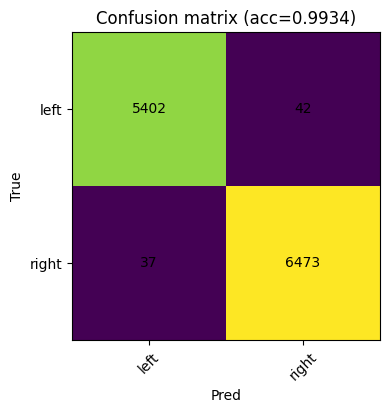

Eval acc: 0.993391333444872
CM:
 [[5402   42]
 [  37 6473]]
Num errors collected: 24


In [30]:
# pick one game to showcase
gid = "5"
data_dir = Path("work/team_crops_game") / f"game_{gid}"

model, metrics = train_resnet_on_folder(data_dir, epochs=3, lr=1e-4, batch=32)
print("Training metrics:", metrics)

out = eval_with_confusion(model, data_dir, batch=64, max_errors=24)
print("Eval acc:", out["acc"])
print("CM:\n", out["cm"])
print("Num errors collected:", len(out["errors"]))


<h2> Annotated video!

In [31]:
import cv2
import json
from pathlib import Path
import numpy as np

def make_gt_demo_video(seq_dir, out_mp4, max_seconds=20, fps_out=25):
    seq_dir = Path(seq_dir)
    labels_path = seq_dir / "Labels-GameState.json"
    lab = json.loads(labels_path.read_text(encoding="utf-8"))

    img_dir = seq_dir / lab["info"]["im_dir"]
    frame_rate = int(lab["info"].get("frame_rate", 25))
    max_frames = int(max_seconds * frame_rate)

    # image_id -> file_name
    img_id_to_name = {im["image_id"]: im["file_name"] for im in lab["images"]}
    img_ids = sorted(img_id_to_name.keys(), key=lambda s: int(s))[:max_frames]

    # group annotations per image_id
    anns_by_img = defaultdict(list)
    for a in lab["annotations"]:
        if a.get("supercategory") == "object":
            anns_by_img[a["image_id"]].append(a)

    # read first frame to init video writer
    first = cv2.imread(str(img_dir / img_id_to_name[img_ids[0]]))
    H, W = first.shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    vw = cv2.VideoWriter(str(out_mp4), fourcc, fps_out, (W, H))

    for k, img_id in enumerate(img_ids):
        frame = cv2.imread(str(img_dir / img_id_to_name[img_id]))
        if frame is None:
            continue

        for a in anns_by_img.get(img_id, []):
            attrs = a.get("attributes", {})
            role = attrs.get("role")
            team = attrs.get("team")  # left/right
            if role not in ["player","goalkeeper","referee","ball"]:
                continue

            b = a.get("bbox_image") or {}
            x = b.get("x"); y = b.get("y"); w = b.get("w"); h = b.get("h")
            if None in [x,y,w,h]:
                continue

            x1,y1,x2,y2 = int(x), int(y), int(x+w), int(y+h)
            x1 = max(0,x1); y1 = max(0,y1); x2 = min(W-1,x2); y2 = min(H-1,y2)

            # draw box
            cv2.rectangle(frame, (x1,y1), (x2,y2), (255,255,255), 2)

            # label
            jersey = attrs.get("jersey", "")
            txt = f"{role} {team}"
            if jersey not in [None,"","null"]:
                txt += f" #{jersey}"
            cv2.putText(frame, txt, (x1, max(20,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        # add small frame counter
        cv2.putText(frame, f"{k+1}/{len(img_ids)}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2)
        vw.write(frame)

    vw.release()
    print("Saved:", out_mp4)

# Example: pick a clip folder you have
make_gt_demo_video(r"data\SoccerNetGS\train\SNGS-060", "work/demo_gt_SNGS060.mp4", max_seconds=20, fps_out=25)


Saved: work/demo_gt_SNGS060.mp4


In [32]:
import json
from pathlib import Path

def find_one_clip_by_game_id(data_root, game_id, preferred_split=None):
    data_root = Path(data_root)
    candidates = list(data_root.rglob("Labels-GameState.json"))
    for p in candidates:
        try:
            lab = json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            continue
        if str(lab.get("info", {}).get("game_id")) != str(game_id):
            continue

        # optionally prefer a split like "valid" or "test"
        if preferred_split:
            parts = p.parts
            if "SoccerNetGS" in parts:
                sp = parts[parts.index("SoccerNetGS")+1]
                if sp != preferred_split:
                    continue

        return p.parent  # sequence folder (SNGS-XXX)
    return None

DATA_ROOT = r"data\SoccerNetGS"
GAME_ID = "5"  # <-- pick another match id (you already have 2 and 5)
SEQ_DIR = find_one_clip_by_game_id(DATA_ROOT, GAME_ID, preferred_split=None)

print("Chosen clip:", SEQ_DIR)

OUT = Path("work") / f"demo_gt_game{GAME_ID}_{Path(SEQ_DIR).name}.mp4"
make_gt_demo_video(str(SEQ_DIR), str(OUT), max_seconds=20, fps_out=25)


Chosen clip: data\SoccerNetGS\valid\SNGS-078
Saved: work\demo_gt_game5_SNGS-078.mp4


<h2> USING YOLO WITH CONFIDENCE AND PREDICTION ACCURACY INSTEAD OF LABELS OF THE JSON FILE

In [34]:
from pathlib import Path
DATA_ROOT = Path(r"data\SoccerNetGS")


In [35]:
import json

def find_one_clip_by_game_id(data_root: Path, game_id: str, preferred_split=None):
    for p in data_root.rglob("Labels-GameState.json"):
        try:
            lab = json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            continue
        if str(lab.get("info", {}).get("game_id")) != str(game_id):
            continue

        if preferred_split:
            parts = p.parts
            if "SoccerNetGS" in parts:
                sp = parts[parts.index("SoccerNetGS")+1]
                if sp != preferred_split:
                    continue

        return p.parent  # SNGS-XXX folder
    return None

for gid in ["2", "5"]:
    seq = find_one_clip_by_game_id(DATA_ROOT, gid)
    print("game_id", gid, "->", seq)


game_id 2 -> data\SoccerNetGS\valid\SNGS-021
game_id 5 -> data\SoccerNetGS\valid\SNGS-078


In [36]:
import json

def find_one_clip_by_game_id(data_root: Path, game_id: str, preferred_split=None):
    for p in data_root.rglob("Labels-GameState.json"):
        try:
            lab = json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            continue
        if str(lab.get("info", {}).get("game_id")) != str(game_id):
            continue

        if preferred_split:
            parts = p.parts
            if "SoccerNetGS" in parts:
                sp = parts[parts.index("SoccerNetGS")+1]
                if sp != preferred_split:
                    continue

        return p.parent  # SNGS-XXX folder
    return None

for gid in ["2", "5"]:
    seq = find_one_clip_by_game_id(DATA_ROOT, gid)
    print("game_id", gid, "->", seq)


game_id 2 -> data\SoccerNetGS\valid\SNGS-021
game_id 5 -> data\SoccerNetGS\valid\SNGS-078


In [40]:
from pathlib import Path

RUNS_DIR = Path(r"work\runs")  # adjust if your runs are elsewhere
cands = list(RUNS_DIR.rglob("weights/best.pt"))

print("Found best.pt:", len(cands))
for p in sorted(cands, key=lambda x: x.stat().st_mtime, reverse=True)[:10]:
    print(p)

assert len(cands) > 0, f"No best.pt found under {RUNS_DIR}"
MODEL_PATH = sorted(cands, key=lambda x: x.stat().st_mtime, reverse=True)[0]
print("\nUsing:", MODEL_PATH)


Found best.pt: 1
work\runs\yolo_gamestate_v13_seq060\weights\best.pt

Using: work\runs\yolo_gamestate_v13_seq060\weights\best.pt


In [41]:
from ultralytics import YOLO

yolo_model = YOLO(str(MODEL_PATH))
print("Loaded YOLO:", MODEL_PATH)


Loaded YOLO: work\runs\yolo_gamestate_v13_seq060\weights\best.pt


In [43]:
import json
import cv2
from pathlib import Path

KEEP_NAMES = ["player", "goalkeeper", "referee", "ball", "other"]  # must match training order

def make_yolo_demo_video(seq_dir, out_mp4, max_seconds=20, conf=0.25, imgsz=640, fps_out=25):
    seq_dir = Path(seq_dir)
    lab = json.loads((seq_dir / "Labels-GameState.json").read_text(encoding="utf-8"))

    img_dir = seq_dir / lab["info"]["im_dir"]
    frame_rate = int(lab["info"].get("frame_rate", 25))
    max_frames = int(max_seconds * frame_rate)

    img_id_to_name = {im["image_id"]: im["file_name"] for im in lab["images"]}
    img_ids = sorted(img_id_to_name.keys(), key=lambda s: int(s))[:max_frames]

    first = cv2.imread(str(img_dir / img_id_to_name[img_ids[0]]))
    H, W = first.shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    vw = cv2.VideoWriter(str(out_mp4), fourcc, fps_out, (W, H))

    for k, img_id in enumerate(img_ids):
        frame = cv2.imread(str(img_dir / img_id_to_name[img_id]))
        if frame is None:
            continue

        res = yolo_model.predict(frame, conf=conf, imgsz=imgsz, verbose=False)[0]
        boxes = res.boxes

        if boxes is not None and len(boxes) > 0:
            xyxy = boxes.xyxy.cpu().numpy()
            cls  = boxes.cls.cpu().numpy().astype(int)
            scr  = boxes.conf.cpu().numpy()

            for (x1,y1,x2,y2), c, s in zip(xyxy, cls, scr):
                x1,y1,x2,y2 = map(int, [x1,y1,x2,y2])
                x1 = max(0,x1); y1 = max(0,y1); x2 = min(W-1,x2); y2 = min(H-1,y2)

                cv2.rectangle(frame, (x1,y1), (x2,y2), (255,255,255), 2)
                name = KEEP_NAMES[c] if 0 <= c < len(KEEP_NAMES) else f"cls{c}"
                cv2.putText(frame, f"{name} {s:.2f}", (x1, max(20,y1-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        cv2.putText(frame, f"{seq_dir.name} frame {k+1}/{len(img_ids)} conf={conf}",
                    (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

        vw.write(frame)

    vw.release()
    print("Saved:", out_mp4)


In [44]:
from pathlib import Path

# Ensure DATA_ROOT is a Path
DATA_ROOT = Path(r"data\SoccerNetGS")

for gid in ["2", "5"]:
    seq = find_one_clip_by_game_id(DATA_ROOT, gid)
    assert seq is not None, f"No clip found for game_id {gid}"
    out = Path("work") / f"demo_yolo_game{gid}_{Path(seq).name}_conf025.mp4"
    make_yolo_demo_video(seq, out, max_seconds=20, conf=0.25, imgsz=640, fps_out=25)


Saved: work\demo_yolo_game2_SNGS-021_conf025.mp4
Saved: work\demo_yolo_game5_SNGS-078_conf025.mp4
